# Template matching with noise
This repo demonstrate the robustness of template matching against noise.
The following script run 2 detections with the same template, image and parameters.
Only for the second detection we introduce some random noise in the image.

In [1]:
# Install matplotlib if not already installed
# it is used in this notebook, but is otherwise not an actual dependency of MTM
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Laurent.Thomas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# 1st import the package and check its version
import MTM
print("MTM version : ", MTM.__version__)

from MTM import matchTemplates, drawBoxesOnRGB

import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

MTM version :  2.0.0


Let's open one image from the Zenodo repo using scikit-image

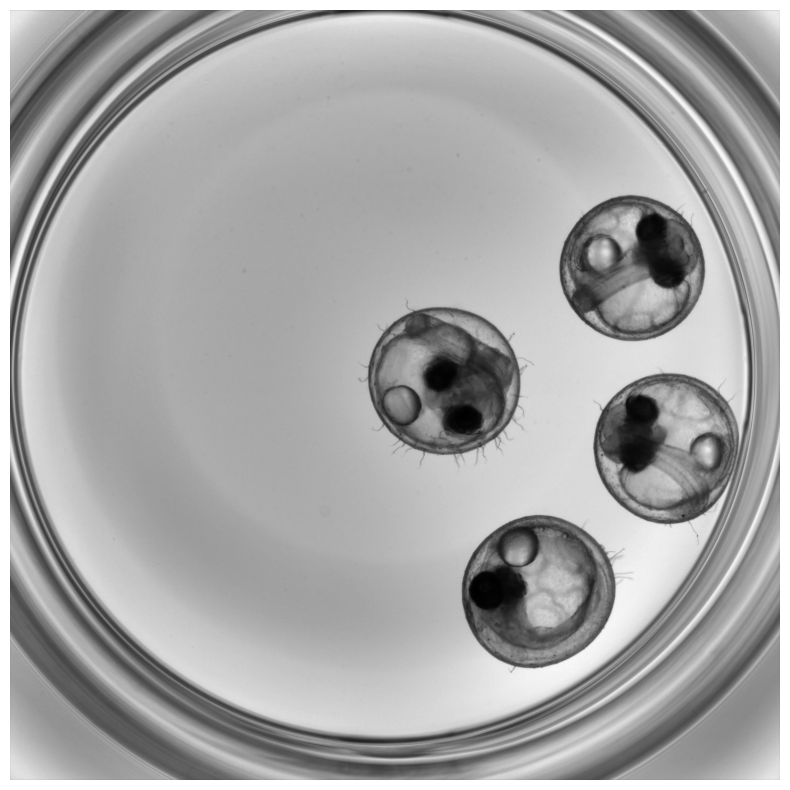

In [3]:
URL = r"https://zenodo.org/record/2650147/files/WE00049---E001--PO01--LO001--CO6--00000000_00.01.00_00.16.00%2C000.jpg"
image = io.imread(URL)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(image, cmap="gray")

Let's crop one of the embryo to use as a template.

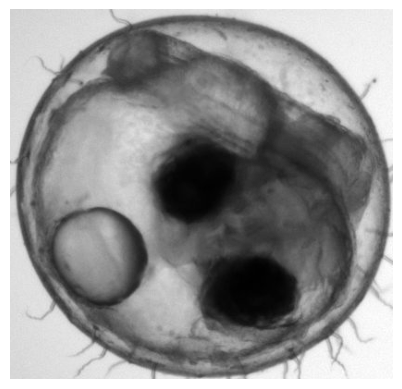

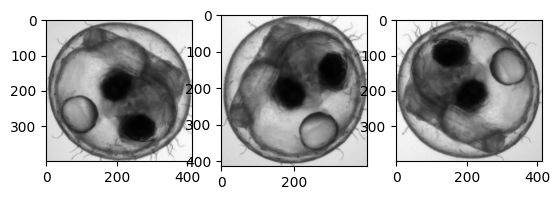

In [4]:
temp0 = image[784:784+400, 946:946+414] # with well 49 
plt.axis("off")
plt.imshow(temp0, cmap="gray")

listTemplate = [("0", temp0)]

# Initialise figure
f, axarr = plt.subplots(1,3)
axarr[0].imshow(temp0, cmap="gray")

for i,angle in enumerate([90,180]):
    rotated = np.rot90(temp0, k=i+1) # NB: rotate not good here, turns into float!
    listTemplate.append( (str(angle), rotated ) )
    axarr[i+1].imshow(rotated, cmap="gray")

We can now call `matchTemplates` with this single template image and the initial image

In [5]:
listHits = matchTemplates(listTemplate, image, N_object=4, score_threshold=0.3, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)
print(listHits)

[('0', (946, 784, 414, 400), 1.0), ('180', (1525, 968, 414, 400), 0.5919372), ('180', (1173, 1354, 414, 400), 0.55106765), ('90', (1459, 474, 400, 414), 0.5381054)]


# Adding noise
Let see the effect on the detection when we add noise to the initial image.

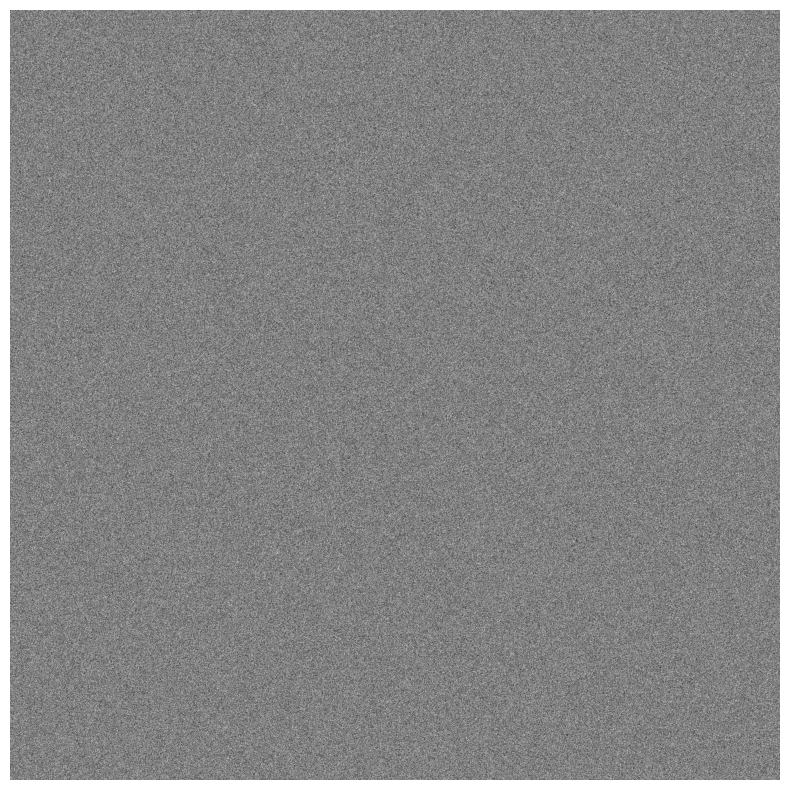

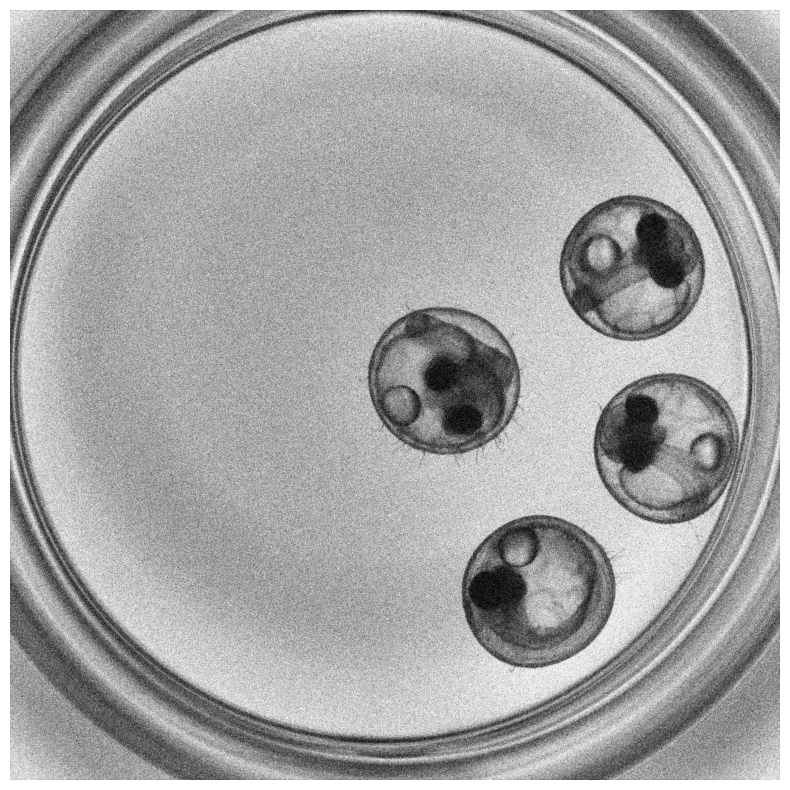

In [6]:
# Generate gaussian distributed noise, the noise intensity is set by the level variable
noise = np.empty_like(image, dtype="int8")
level = 50
cv2.randn(noise,(0),(level)) # Matrix element are 0 in average
                
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(noise, cmap="gray")

imageNoise = cv2.add(image,noise, dtype=cv2.CV_8U)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(imageNoise, cmap="gray")

In [10]:
# Call again matchTemplates with the noisy image this time, but the same template
listHits_Noise = matchTemplates(listTemplate, imageNoise, N_object=4,  score_threshold=0.3, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)

def pretty_print(listHits):
    print(np.array(listHits, dtype=object))

print("Initial detections")
pretty_print(listHits)

print("\nDetections with noise")
pretty_print(listHits_Noise)

Initial detections
[['0' (946, 784, 414, 400) 1.0]
 ['180' (1525, 968, 414, 400) 0.5919372]
 ['180' (1173, 1354, 414, 400) 0.55106765]
 ['90' (1459, 474, 400, 414) 0.5381054]]

Detections with noise
[['0' (946, 784, 414, 400) 0.766042]
 ['180' (1524, 968, 414, 400) 0.46325678]
 ['180' (1172, 1354, 414, 400) 0.43588048]
 ['90' (1459, 474, 400, 414) 0.43311062]]


The coordinates of the bounding boxes are slightly shifted by a few pixels with the noisy version of the image, and as we could expect the score is also reduced.

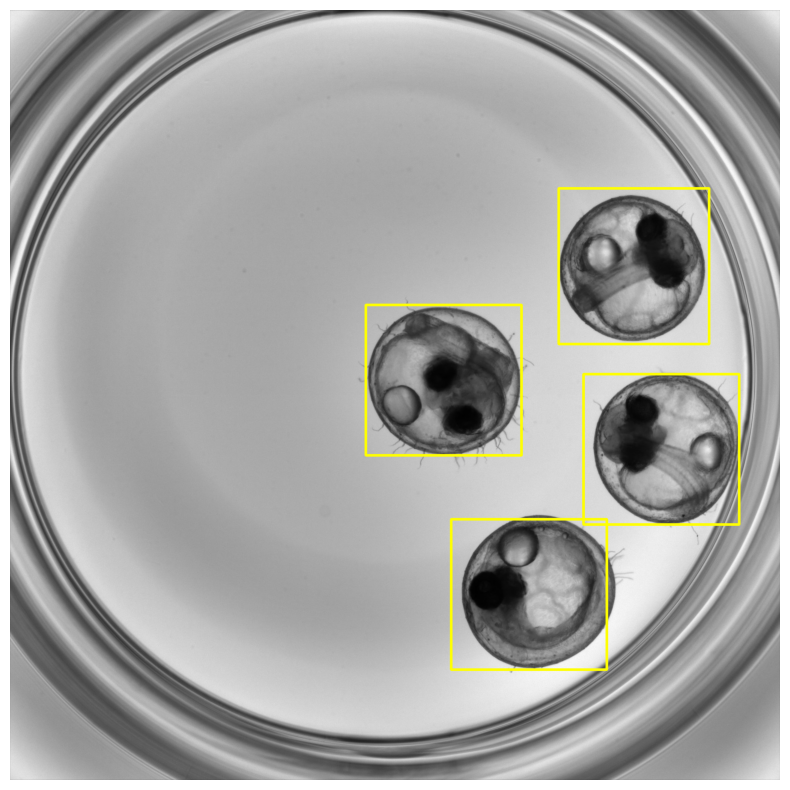

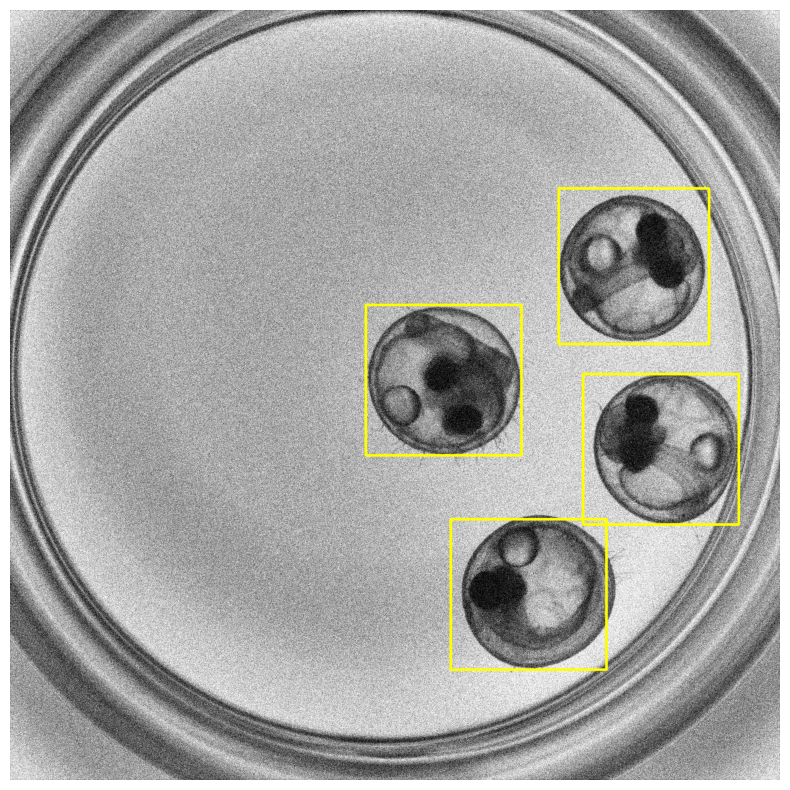

In [11]:
Overlay1 = drawBoxesOnRGB(image, listHits, boxThickness=5)
Overlay2 = drawBoxesOnRGB(imageNoise, listHits_Noise, boxThickness=5) 

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay1)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay2)